In [23]:
%matplotlib inline
import matplotlib
import numpy as np
import tensorflow as tf
input_data = tf.keras.datasets.mnist
import sklearn.gaussian_process as gp
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import pandas as pd
import math
from math import exp, pi, log
import scipy
from scipy.stats import norm
from scipy import optimize
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm #add progress bar to for loops

import plotters

# Bayesian Optimization Code

In [21]:
def expected_improvement(x, gp, eval_loss, g_i_b = False, n_params = 1):
    """ Calculate Expected Improvement Acquisition Function """
    x_to_predict = x.reshape(-1, n_params)
    mu, sigma = gp.predict(x_to_predict, return_std=True)
    if g_i_b:
        loss_optimum = np.max(eval_loss)
    else:
        loss_optimum = np.min(eval_loss)
    scaling_factor = (-1)**(not g_i_b)
    # In case if sigma==0
    with np.errstate(divide="ignore"):
        Z = scaling_factor*(mu-loss_optimum)/sigma
        expected_improvement = scaling_factor*(mu-loss_optimum)*norm.cdf(Z)+sigma*norm.pdf(Z)
        expected_improvement[sigma==0.0]==0.0
        
    return -1*expected_improvement

def sample_next_parameter(acq_fn, gp, eval_loss, g_i_b=False, bounds=(0,10),n_restarts=25):
    """ Propose next parameter to sample loss function for """
    best_x = None
    best_acquisition_value = 1
    n_params=bounds.shape[0]
    for starting_point in np.random.uniform(bounds[:,0],bounds[:,1],size=(n_restarts, n_params)):
        res = minimize(fun=acq_fn, x0=starting_point.reshape(1,-1), bounds=bounds, method='L-BFGS-B',
                      args=(gp, eval_loss, g_i_b, n_params))
        
        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x
    return best_x

def bayesian_optimization(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5, gp_params=None, random_search=False, alpha=1e-5,epsilon=1e-7):
    " Use GPs to optimize the loss function 'sample_loss'"
    x_list = []
    y_list = []
    n_params=bounds.shape[0]
    if x0 is None:
        for params in np.random.uniform(bounds[:,0], bounds[:,1],(n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))
    
    xp = np.array(x_list)
    yp = np.array(y_list)
    
    # Create GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10, normalize_y=True)
        
    for n in range(n_iters):
        model.fit(xp,yp)
        if random_search:
            x_random = np.random.uniform(bounds[:,0], bounds[:,1], size=(random_search, n_params))
            ei = -1*expected_improvement(x_random, model, yp, g_i_b=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_parameter(expected_improvement, model, yp, g_i_b=True, bounds=bounds, n_restarts=100)

        # In case of duplicates, we will randomly sample next query point
        if np.any(np.abs(next_sample - xp)<=epsilon):
            next_sample = np.random.uniform(bounds[:,0], bounds[:,1], bounds.shape[0])

        cv_score = sample_loss(next_sample)
        x_list.append(next_sample)
        y_list.append(cv_score)

        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

In [10]:
data, target = make_classification(n_samples=2500,n_features=45,n_informative=15,n_redundant=5)

def sample_loss(params):
    return cross_val_score(SVC(C=10**params[0], gamma=10**params[1], random_state=12345),
                          X = data, y= target, scoring='roc_auc', cv=3).mean()

lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)

param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])
real_loss = [sample_loss(params) for params in param_grid]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [11]:
# max is at:
param_grid[np.array(real_loss).argmax(),:]

array([ 0.375     , -2.15789474])

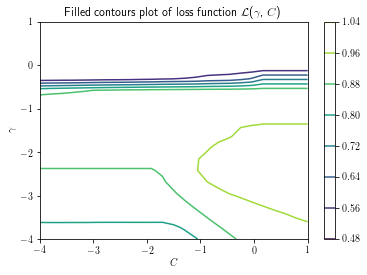

In [16]:
from matplotlib import rc
rc('text', usetex=True)
C,G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contour(C,G,np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma$')
plt.savefig('./real_loss_contour.png', bbox_inches='tight')
plt.show()

In [24]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimization(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

In [11]:
from hyperopt import hp, tpe, fmin
from math import sin, pi
from hyperopt.pyll.stochastic import sample
import matplotlib.pyplot as plt

In [12]:
def minimize(x):
    return sin(x)

In [13]:
best = fmin(fn=lambda x: minimize(x),
            space=hp.normal('x', 0, pi),
            algo=tpe.suggest, 
            max_evals=2000)

100%|██████████| 2000/2000 [00:09<00:00, 221.10trial/s, best loss: -0.9999999580524378]


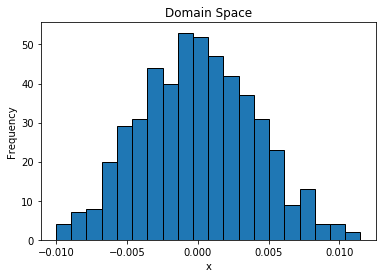

In [56]:
space = hp.normal('x', 0.00001, 0.004)

samples = []

# Sample 10000 values from the range
for _ in range(500):
    samples.append(sample(space))
    
# Histogram of the values
plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

In [ ]:
space = hp.qnormal()

In [58]:
a = [[3, 29, 3, 7, 12, 30, 3, 4, 8, 3, 3, 3, 8, 3, 15, 8, 3, 11, 6, 3, 3, 3], [3, 6, 3, 4, 3, 4, 3, 3, 3, 3, 9, 3, 3, 3]]
a[1].extend(0)

TypeError: 'int' object is not iterable